# Temperature Control for Chocolate Tempering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_context('talk')

## Temperature Trajectory Specification

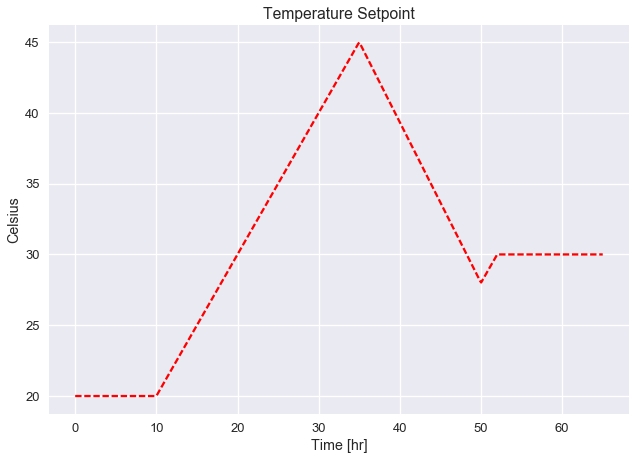

In [2]:
# Create a setpoint function using linear interpolation
tbreak = [0, 10, 35, 50, 52, 65]
Tbreak = [20,20,45,28,30,30]
Tsp = interp1d(tbreak,Tbreak,kind='linear')

t = np.linspace(0,65,500)
plt.plot(t,Tsp(t),'r--')
plt.title('Temperature Setpoint')
plt.xlabel('Time [hr]')
plt.ylabel('Celsius')

## Model

\begin{align*}
\frac{dT}{dt} & = a(T_j - T) \\
\frac{dT_j}{dt} & = a(T - T_j) + Q_c(T_c - T_j) + b Q_s
\end{align*}

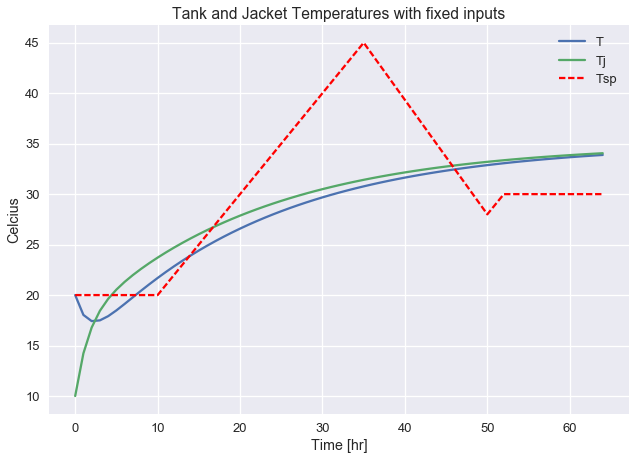

In [39]:
Tc = 10       # cold water temperature
Qc = 0.1      # cold water flow
Qs = 0.25     # steam flow

def deriv(X,t):
    T,Tj = X
    dT =   0.3*(Tj - T)
    dTj = -0.3*(Tj - T) + Qc*(Tc - Tj) + Qs*10.0
    return [dT,dTj]

IC = [20,10]

X = odeint(deriv,IC,t)
T,Tj = X.transpose()

plt.plot(t,T,t,Tj,t,Tsp(t),'r--')
plt.title('Tank and Jacket Temperatures with fixed inputs')
plt.xlabel('Time [hr]')
plt.ylabel('Celcius')
plt.legend(['T','Tj','Tsp'])

## Simple Proportional-Integral Control

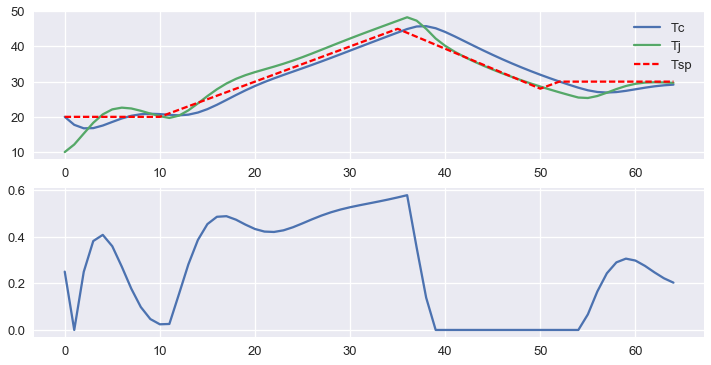

In [70]:
dt = 1       # sample time

log = []     # initialize data log
I = 0        # initialize error sum
T,Tj = IC    # initial condition on states
Qs = 0.25    # initial condition on manipulated variable

for t in np.arange(0,65,dt):
    log.append([t,T,Tj,Qs])
    E = (Tsp(t) - T)
    I += E
    Qs = max(0,0.1*E + 0.01*I)
    T,Tj = odeint(deriv,[T,Tj],[t,t+dt])[-1]

t,T,Tj,Qs = np.asarray(log).T

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t,T,t,Tj,t,Tsp(t),'r--')
plt.legend(['Tc','Tj','Tsp'])

plt.subplot(2,1,2)
plt.plot(t,Qs)   

## Cascade Control

In [41]:
import matplotlib.pyplot as plt
import numpy as np

class PID:
    """ An implementation of a PID control class for use in process control simulations.
    """
    def __init__(self, name=None, SP=None, Kp=0.2, Ki=0, Kd=0, beta=1, gamma=0, MVrange=(0,100), DirectAction=False):
        self.name = name
        self.SP = SP
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.beta = beta
        self.gamma = gamma
        self.MVrange = MVrange
        self.DirectAction = DirectAction
        self._mode = 'inAuto'
        self._log = []
        self._errorP0 = 0
        self._errorD0 = 0
        self._errorD1 = 0
        self._lastT = 0
        self._currT = 0
        
    def auto(self,t=None,SP=None):
        """Change to automatic control mode.
        """
        self.SP = SP
        self._mode = 'inAuto'
        
    def manual(self,t):
        """Change to manual control mode. In manual mode, the setpoint tracks the process 
        variable to provide bumpless transfer on return to auto.
        """
        self._lastT = t
        self._mode = 'inManual'
        
    def _logger(self,t,SP,PV,MV):
        self._log.append([t,SP,PV,MV])
        
    def plot(self):
        """Create historical plot of SP,PV, and MV using the controller's internal log file.
        """
        dlog = np.asarray(self._log).T
        t,SP,PV,MV = dlog
        plt.subplot(2,1,1)
        plt.plot(t,PV,t,SP)
        plt.title('Process Variable')
        plt.xlabel('Time')
        plt.legend(['PV','SP'])
        plt.subplot(2,1,2)
        plt.plot(t,MV)
        plt.title('Manipulated Variable')
        plt.xlabel('Time')
        plt.tight_layout()
    
    @property
    def beta(self):
        """beta is the setpoint weighting for proportional control where the proportional error
        is given by error_proportional = beta*SP - PV. The default value is one.
        """
        return self._beta
        
    @beta.setter
    def beta(self,beta):
        self._beta = max(0.0,min(1.0,beta))
        
    @property
    def DirectAction(self):
        """DirectAction is a logical variable setting the direction of the control. A True
        value means the controller output MV should increase for PV > SP. If False the controller
        is reverse acting, and ouput MV will increase for SP > PV. IFf the steady state
        process gain is positive then a control will be reverse acting. 
        
        The default value is False.
        """
        return self._DirectAction
    
    @DirectAction.setter
    def DirectAction(self,DirectAction):
        if DirectAction:
            self._DirectAction = True
            self._action = +1.0
        else:
            self._DirectAction = False
            self._action = -1.0
    
    @property
    def gamma(self):
        """gamma is the setpoint weighting for derivative control where the derivative error
        is given by gamma*SP - PV.  The default value is zero. 
        """
        return self._gamma
    
    @gamma.setter
    def gamma(self,gamma):
        self._gamma = max(0.0,min(1.0,gamma))
    
    @property
    def Kp(self):
        """Kp is the proportional control gain.
        """
        return self._Kp
    
    @Kp.setter
    def Kp(self,Kp):
        self._Kp = Kp
    
    @property
    def Ki(self):
        """Ki is the integral control gain.
        """
        return self._Ki
        
    @Ki.setter
    def Ki(self,Ki):
        self._Ki = Ki
    
    @property
    def Kd(self):
        """Kd is the derivative control gain.
        """
        return self._Kd
    
    @Kd.setter
    def Kd(self,Kd):
        self._Kd = Kd
        
    @property
    def MV(self):
        """MV is the manipulated (or PID outpout) variable.
        """
        return self._MV
    
    @MV.setter
    def MV(self,MV):
        self._MV = max(self._MVmin,min(self._MVmax,MV))
        
    @property
    def MVrange(self):
        """range is a tuple specifying the minimum and maximum controller output.
        Default value is (0,100).
        """
        return (self._MVmin,self._MVmax)
    
    @MVrange.setter
    def MVrange(self,MVrange):
        self._MVmin = MVrange[0]
        self._MVmax = MVrange[1]

    @property
    def SP(self):
        """SP is the setpoint for the measured process variable.
        """
        return self._SP
    
    @SP.setter
    def SP(self,SP):
        self._SP = SP
        
    @property
    def PV(self):
        """PV is the measured process (or control) variable.
        """
        return self._PV
    
    @PV.setter
    def PV(self,PV):
        self._PV = PV

    def update(self,t,SP,PV,MV):
        self.SP = SP
        self.PV = PV
        self.MV = MV 
        if t > self._lastT:
            dt = t - self._lastT
            self._lastT = t
            if self._mode=='inManual':
                self.SP = PV
            self._errorP1 = self._errorP0
            self._errorP0 = self.beta*self.SP - self.PV
            self._errorI0 = self.SP - self.PV            
            self._errorD2 = self._errorD1
            self._errorD1 = self._errorD0
            self._errorD0 = self.gamma*self.SP - self.PV
            if self._mode=='inAuto':
                self._deltaMV = self.Kp*(self._errorP0 - self._errorP1) \
                    + self.Ki*dt*self._errorI0 \
                    + self.Kd*(self._errorD0 - 2*self._errorD1 + self._errorD2)/dt
                self.MV -= self._action*self._deltaMV

        self._logger(t,self.SP,self.PV,self.MV)
        return self.MV 


<function __main__.sim>

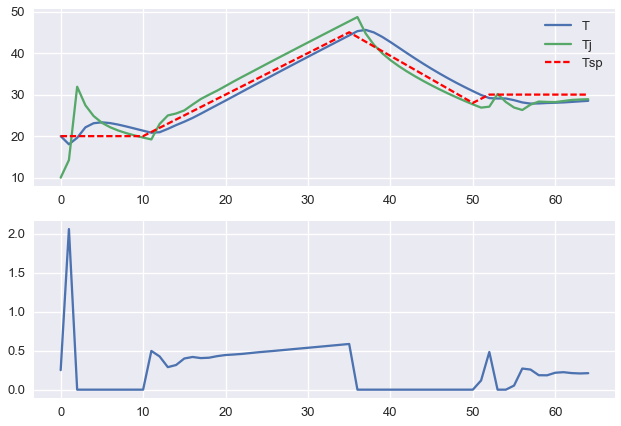

In [71]:
from ipywidgets import interact

dt = 1       # sample time

log = []     # initialize data log
I = 0        # initialize error sum
T,Tj = IC    # initial condition on states
Qs = 0.25    # initial condition on manipulated variable

def sim(KpSlider= 0.1, KiSlider = 0.01):
    
    global Qs

    log = []
    [T,Tj] = IC    
    Qs = 0.25
    Tr = 20

    # tank PID
    tPID = PID(Kp = 5, Ki=2, Kd=.1, MVrange=(-60,60))
    
    # jacket PID
    jPID = PID(Kp = KpSlider, Ki = KiSlider, Kd = 0.01, MVrange=(0,10),beta=1)
    
    for t in np.arange(0,65,dt):
        tPID.SP = Tsp(t)
        Tr = tPID.update(t,Tsp(t),T,Tr)
        Qs = jPID.update(t,Tr,Tj,Qs)
        log.append([t,T,Tj,Tr,Qs])
        T,Tj = odeint(deriv,[T,Tj],[t,t+dt])[-1]

    t,T,Tj,Tr,Qs = np.asarray(log).T

    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t,T,t,Tj,t,Tsp(t),'r--')
    plt.legend(['T','Tj','Tsp'])

    plt.subplot(2,1,2)
    plt.plot(t,Qs)

interact(sim,KpSlider=(0,.5,.01),KiSlider=(0,.2,.001))